In [1]:
import numpy as np
from OpenEphys import loadContinuous
import os
import glob
from scipy import signal as ss
from scipy import stats as st
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
#Select file for analysis
files_to_be_converted = ['Pre 1','Pre 2','Pre 3','Cit 1','Cit 2','Cit 3','Way 1', 'Way 2','Way 3']
source_folder = r'/Users/sharplab/tran/EEG data'

path = "/".join([source_folder,files_to_be_converted[1]])
os.chdir(path)
file = glob.glob("*.continuous")
print(file[0])
eegdata = loadContinuous(file[0], dtype=float)
array = eegdata['data']



100_CH43.continuous
Loading continuous data...


In [5]:
def butter_lowpass(low_cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_low_cutoff = low_cutoff / nyq
    b_low, a_low = butter(order, normal_low_cutoff, btype='low', analog=False)
    return b_low, a_low

def butter_highpass(high_cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_high_cutoff = high_cutoff / nyq
    b_high, a_high = butter(order, normal_high_cutoff, btype='high', analog=False)
    return b_high, a_high

def butter_lowpass_filter(data, low_cutoff, fs, order=5):
    b_low, a_low = butter_lowpass(low_cutoff, fs, order=order)
    y_low = ss.filtfilt(b_low, a_low, data)
    return y_low

def butter_highpass_filter(data, high_cutoff, fs, order=5):
    b_high, a_high = butter_highpass(high_cutoff, fs, order=order)
    y_high = ss.filtfilt(b_high, a_high, data)
    return y_high

# Filter requirements.
order = 5
fs = 30000      # sample rate, Hz
low_cutoff = 100 # desired cutoff frequency of the filter, Hz
high_cutoff = 5

print('Filtering data')
#filtered_array = butter_lowpass_filter(array, low_cutoff, fs, order)
filtered_array = butter_highpass_filter(array, high_cutoff, fs, order)

Filtering data


In [76]:
#Resampling the data
updated_array=ss.decimate(filtered_array, 12, ftype = 'fir')
newarray = ss.decimate(updated_array,10, ftype = 'fir')

In [77]:
sampling_rate = 250
bin_size = sampling_rate * 4

binned_frequencies, binned_time, binned_Sxx = ss.spectrogram(newarray,sampling_rate, ss.get_window('hamming', bin_size), noverlap=0, nfft=bin_size)


/Users/sharplab/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1657: RuntimeWarning: overflow encountered in multiply
  result = np.conjugate(result) * result
/Users/sharplab/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1657: RuntimeWarning: invalid value encountered in multiply
  result = np.conjugate(result) * result
/Users/sharplab/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1659: RuntimeWarning: invalid value encountered in multiply
  result *= scale


In [40]:
df = pd.DataFrame(data=binned_Sxx,
                     index=binned_frequencies)

df.head()

,0
0.00,3248.402938
0.25,24852.820736
0.50,23624.935168
0.75,16921.124910
1.00,11483.441804


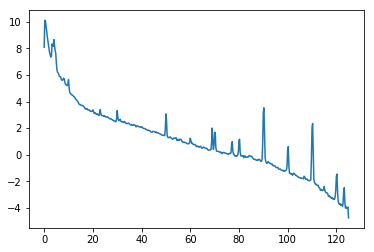

In [57]:
#Plot the end result
df_lowf = df.iloc[:]
plt.plot(df_lowf.index, np.log(df_lowf))
plt.show()

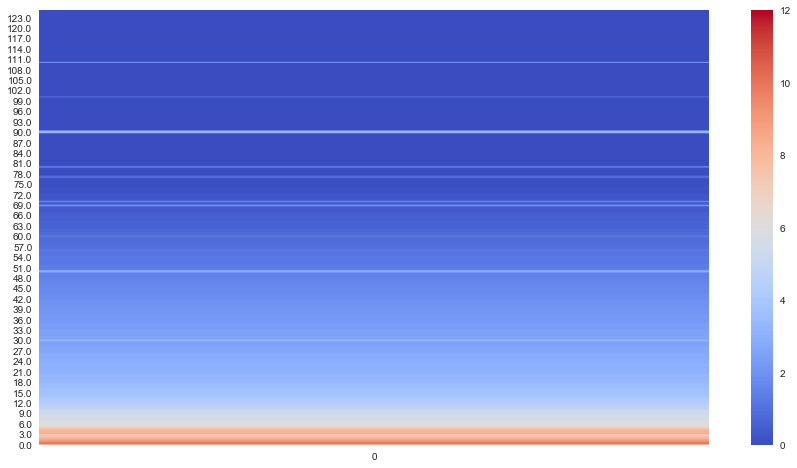

In [59]:
sns.set()
f, a = plt.subplots(figsize=(15,8))

a = sns.heatmap(np.log(df_lowf), cmap='coolwarm', vmin=0, vmax=12)

a.invert_yaxis()
plt.show()

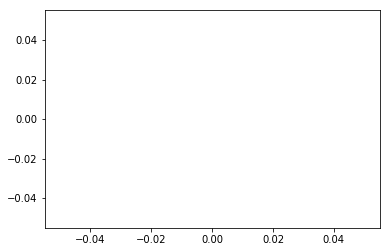

In [9]:
plt.plot(filtered_array[:])